In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Installation Spark

In [ ]:
# installation de jdk java
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# Installation de spark
!wget -q https://archive.apache.org/dist/spark/spark-3.0.3/spark-3.0.3-bin-hadoop2.7.tgz
!tar xf spark-3.0.3-bin-hadoop2.7.tgz
!pip install pyspark==3.0.3

# Importation de fichier .jar
!wget -q https://repo1.maven.org/maven2/org/apache/hadoop/hadoop-aws/2.7.4/hadoop-aws-2.7.4.jar
!wget -q https://repo1.maven.org/maven2/com/amazonaws/aws-java-sdk/1.7.4/aws-java-sdk-1.7.4.jar
!mv /content/aws-java-sdk-1.7.4.jar /content/spark-3.0.3-bin-hadoop2.7/jars/
!mv /content/hadoop-aws-2.7.4.jar /content/spark-3.0.3-bin-hadoop2.7/jars/

# Installation de findspark
!pip install -q findspark
!ls

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backpor

In [ ]:
import os

# Variables d'environnement java et spark
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.3-bin-hadoop2.7"

In [ ]:
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession

# Variables d'environnement permettant la connexion avec AWS
os.environ['AWS_PROFILE'] = 'default'
os.environ['AWS_ACCESS_KEY_ID'] = '***'
os.environ['AWS_SECRET_ACCESS_KEY'] = '***'
os.environ['PYSPARK_SUBMIT_ARGS'] = f'--jars {os.environ["SPARK_HOME"]}/jars/hadoop-aws-2.7.4.jar,{os.environ["SPARK_HOME"]}/jars/aws-java-sdk-1.7.4.jar pyspark-shell'

In [ ]:
spark = SparkSession.builder \
            .appName("my_app") \
            .config('spark.sql.codegen.wholeStage', False) \
            .config('spark.sql.execution.arrow.pyspark.enabled', True) \
            .config('spark.sql.session.timeZone', 'UTC') \
            .config('spark.jars', f'{os.environ["SPARK_HOME"]}/jars/hadoop-aws-2.7.4.jar,{os.environ["SPARK_HOME"]}/jars/aws-java-sdk-1.7.4.jar') \
            .config('spark.driver.extraJavaOptions', '-Dcom.amazonaws.services.s3.enableV4') \
            .config('spark.executor.extraJavaOptions', '-Dcom.amazonaws.services.s3.enableV4') \
            .getOrCreate()

In [ ]:
sc = spark.sparkContext

sc._jsc.hadoopConfiguration().set("fs.s3a.awsAccessKeyId", os.environ.get('AWS_ACCESS_KEY_ID'))
sc._jsc.hadoopConfiguration().set("fs.s3a.awsSecretAccessKey", os.environ.get('AWS_SECRET_ACCESS_KEY'))
sc._jsc.hadoopConfiguration().set("fs.s3a.impl","org.apache.hadoop.fs.s3a.S3AFileSystem")
sc._jsc.hadoopConfiguration().set("com.amazonaws.services.s3.enableV4", "true")
sc._jsc.hadoopConfiguration().set("fs.s3a.aws.credentials.provider", "com.amazonaws.auth.profile.ProfileCredentialsProvider")
sc._jsc.hadoopConfiguration().set("fs.s3a.endpoint", "s3.eu-west-3.amazonaws.com")

## Chargement des données

In [ ]:
# Importation des images depuis bucket S3
images = spark.read.format("binaryfile").load("s3a://pr8/Training/*")

images.printSchema()

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)



In [ ]:
images.show(5)

+--------------------+-------------------+------+--------------------+
|                path|   modificationTime|length|             content|
+--------------------+-------------------+------+--------------------+
|s3a://pr8/Trainin...|2022-02-08 09:50:11|  6371|[FF D8 FF E0 00 1...|
|s3a://pr8/Trainin...|2022-02-08 09:50:11|  5899|[FF D8 FF E0 00 1...|
|s3a://pr8/Trainin...|2022-02-08 09:50:12|  5865|[FF D8 FF E0 00 1...|
|s3a://pr8/Trainin...|2022-02-08 09:50:13|  5756|[FF D8 FF E0 00 1...|
|s3a://pr8/Trainin...|2022-02-08 09:50:25|  5138|[FF D8 FF E0 00 1...|
+--------------------+-------------------+------+--------------------+
only showing top 5 rows



In [ ]:
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, split

# Créer nouvelle colonne 'label'
image_df = images.withColumn('label', split(col('path'), '/').getItem(4))

# Choisir les 3 colonnes nécessaire
image_df = image_df.select('path', 'content', 'label')
image_df.show()

+--------------------+--------------------+------+
|                path|             content| label|
+--------------------+--------------------+------+
|s3a://pr8/Trainin...|[FF D8 FF E0 00 1...|Lychee|
|s3a://pr8/Trainin...|[FF D8 FF E0 00 1...|Lychee|
|s3a://pr8/Trainin...|[FF D8 FF E0 00 1...|Lychee|
|s3a://pr8/Trainin...|[FF D8 FF E0 00 1...|Lychee|
|s3a://pr8/Trainin...|[FF D8 FF E0 00 1...|  Kaki|
|s3a://pr8/Trainin...|[FF D8 FF E0 00 1...| Lemon|
|s3a://pr8/Trainin...|[FF D8 FF E0 00 1...| Lemon|
|s3a://pr8/Trainin...|[FF D8 FF E0 00 1...| Lemon|
|s3a://pr8/Trainin...|[FF D8 FF E0 00 1...|  Kaki|
|s3a://pr8/Trainin...|[FF D8 FF E0 00 1...|  Kaki|
|s3a://pr8/Trainin...|[FF D8 FF E0 00 1...|  Kaki|
|s3a://pr8/Trainin...|[FF D8 FF E0 00 1...| Lemon|
|s3a://pr8/Trainin...|[FF D8 FF E0 00 1...|Banana|
|s3a://pr8/Trainin...|[FF D8 FF E0 00 1...|Banana|
|s3a://pr8/Trainin...|[FF D8 FF E0 00 1...|Banana|
|s3a://pr8/Trainin...|[FF D8 FF E0 00 1...|Banana|
+--------------------+---------

## Extraction des features

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array

Utilisation du modèle ResNet50 pour extraire les features (en excluant la dernière couche car nous ne l'utilisons par pour de la classification mais pour l'extraction de features)

In [ ]:
model = ResNet50(include_top=False)

94781440/94765736 [==============================] - 1s 0us/step


Afin d'éviter d'appeler chaque noeud individuellement on va diffuser le poids du modèle à tous les noeuds

In [ ]:
bc_model_weights = sc.broadcast(model.get_weights())

def model_fn():
    """
    Returns a ResNet50 model with top layer removed and broadcasted pretrained weights.
    """
    model = ResNet50(weights=None, include_top=False)
    model.set_weights(bc_model_weights.value)
    return model

Fonction permettant le pre-processing des images 

In [ ]:
from PIL import Image
import io

def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr) 

Utilisation du modèle sur chaque image afin d'extraire les features 

In [ ]:
def featurize_series(model, content_series):
    
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    
    input = np.stack(content_series.map(preprocess)) 
    preds = model.predict(input)
    output = [p.flatten() for p in preds]
    return pd.Series(output)

Regrouper toutes les fonction précédentes en 1 en utilisant pandas_udf. Ceci permet d'appliquer des fonction sur un dataframe spark en passant par pandas

In [ ]:
from typing import Iterator

@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter) :
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).
  
    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                                is a pandas Series of image data.
    '''
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/pandas/functions.py:386: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  "in the future releases. See SPARK-28264 for more details.", UserWarning)


In [ ]:
# Permet d'éviter les erreurs liées à l'insuffisance de mémoire en limitant le nombre de lignes par lot
spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1024")

In [ ]:
# Remplacer la colonne 'content' par les features extraite
features_df = image_df.select(col("path"), col("label"), featurize_udf("content").alias("features"))
features_df.printSchema()
features_df.show()

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)

+--------------------+------+--------------------+
|                path| label|            features|
+--------------------+------+--------------------+
|s3a://pr8/Trainin...|Lychee|[0.0, 0.0, 0.0, 0...|
|s3a://pr8/Trainin...|Lychee|[0.0, 0.0, 0.0, 0...|
|s3a://pr8/Trainin...|Lychee|[0.0, 0.0, 0.0, 0...|
|s3a://pr8/Trainin...|Lychee|[0.0, 0.0, 0.0, 0...|
|s3a://pr8/Trainin...|  Kaki|[0.0, 0.0, 0.0, 0...|
|s3a://pr8/Trainin...| Lemon|[0.0, 0.0, 0.0, 0...|
|s3a://pr8/Trainin...| Lemon|[0.0, 0.0, 0.0, 0...|
|s3a://pr8/Trainin...| Lemon|[0.0, 0.0, 0.0, 0...|
|s3a://pr8/Trainin...|  Kaki|[0.2651664, 0.0, ...|
|s3a://pr8/Trainin...|  Kaki|[0.0, 0.0, 0.0, 0...|
|s3a://pr8/Trainin...|  Kaki|[0.0, 0.0, 0.0, 0...|
|s3a://pr8/Trainin...| Lemon|[0.0, 0.0, 0.0, 0...|
|s3a://pr8/Trainin...|Banana|[0.0, 0.0, 0.0, 0...|
|s3a://pr8/Trainin.

In [ ]:
from pyspark.sql.functions import udf
from pyspark.ml.linalg import Vectors, VectorUDT


list_to_vector_udf = udf(lambda l: Vectors.dense(l), VectorUDT())
features_df = features_df.select(col("path"),  col("label"), list_to_vector_udf(features_df["features"]).alias("features"))

In [ ]:
features_df.printSchema()

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: vector (nullable = true)



## Réduction de dimension par ACP

Pour pouvoir faire une réduction de dimension il faut que les features soient standardisé

In [ ]:
from pyspark.ml.feature import StringIndexer, StandardScaler
from pyspark.ml.feature import PCA

standardizer = StandardScaler(withMean=True, withStd=True,
                              inputCol='features',
                              outputCol='scaled_feat')
std = standardizer.fit(features_df)
features_df_scaled = std.transform(features_df)

In [ ]:
#Visualisation du nouveau dataframe obtenu
features_df_scaled.printSchema()
features_df_scaled.show(5) 

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: vector (nullable = true)
 |-- scaled_feat: vector (nullable = true)

+--------------------+------+--------------------+--------------------+
|                path| label|            features|         scaled_feat|
+--------------------+------+--------------------+--------------------+
|s3a://pr8/Trainin...|Lychee|[0.0,0.0,0.0,0.0,...|[-0.25,0.0,0.0,0....|
|s3a://pr8/Trainin...|Lychee|[0.0,0.0,0.0,0.0,...|[-0.25,0.0,0.0,0....|
|s3a://pr8/Trainin...|Lychee|[0.0,0.0,0.0,0.0,...|[-0.25,0.0,0.0,0....|
|s3a://pr8/Trainin...|Lychee|[0.0,0.0,0.0,0.0,...|[-0.25,0.0,0.0,0....|
|s3a://pr8/Trainin...|  Kaki|[0.0,0.0,0.0,0.0,...|[-0.25,0.0,0.0,0....|
+--------------------+------+--------------------+--------------------+
only showing top 5 rows



In [ ]:
from pyspark.ml.feature import PCA

pca = PCA(k=16, inputCol="scaled_feat", outputCol="pca")
modelpca = pca.fit(features_df_scaled)
transformed = modelpca.transform(features_df_scaled)

In [ ]:
transformed.printSchema()
transformed.show(3)

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: vector (nullable = true)
 |-- scaled_feat: vector (nullable = true)
 |-- pca: vector (nullable = true)

+--------------------+------+--------------------+--------------------+--------------------+
|                path| label|            features|         scaled_feat|                 pca|
+--------------------+------+--------------------+--------------------+--------------------+
|s3a://pr8/Trainin...|Lychee|[0.0,0.0,0.0,0.0,...|[-0.25,0.0,0.0,0....|[55.9428270752314...|
|s3a://pr8/Trainin...|Lychee|[0.0,0.0,0.0,0.0,...|[-0.25,0.0,0.0,0....|[51.1364085813633...|
|s3a://pr8/Trainin...|Lychee|[0.0,0.0,0.0,0.0,...|[-0.25,0.0,0.0,0....|[47.1744256232098...|
+--------------------+------+--------------------+--------------------+--------------------+
only showing top 3 rows



Text(0, 0.5, 'Variance expliqué (%)')

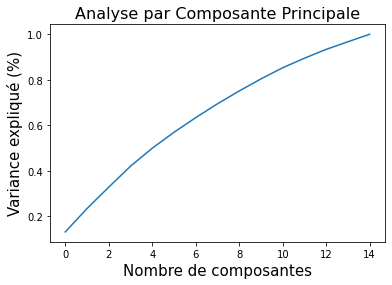

In [ ]:
var = modelpca.explainedVariance.cumsum()

plt.plot(var)
plt.title('Analyse par Composante Principale', size = 16)
plt.xlabel("Nombre de composantes", size =15)
plt.ylabel("Variance expliqué (%)", size =15)

# Enregistrement

In [ ]:
transformed.printSchema()

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: vector (nullable = true)
 |-- scaled_feat: vector (nullable = true)
 |-- pca: vector (nullable = true)



In [ ]:
from pyspark.ml.functions import vector_to_array

df = transformed.withColumn("pca_array", vector_to_array("pca"))\
    .select(["path", "label"] + [col("pca_array")[i] for i in range(9)])


In [ ]:
df.show(2)

+--------------------+------+-----------------+------------------+------------------+------------------+-----------------+-------------------+------------------+-------------------+------------------+
|                path| label|     pca_array[0]|      pca_array[1]|      pca_array[2]|      pca_array[3]|     pca_array[4]|       pca_array[5]|      pca_array[6]|       pca_array[7]|      pca_array[8]|
+--------------------+------+-----------------+------------------+------------------+------------------+-----------------+-------------------+------------------+-------------------+------------------+
|s3a://pr8/Trainin...|Lychee|55.94282707523141|109.39311771575709|-43.09140040012839|-70.86746442246283|51.88364337875799|-0.4682306756607466|2.3443208138116964|-11.062628350834457|-3.485172471712496|
|s3a://pr8/Trainin...|Lychee|51.13640858136338| 85.33756865940617|-40.66071485370171|-56.46045021810719|32.02140241056306| 18.629645869717987| 4.649833711117812| 10.356769324346796|-3.124829902387

In [ ]:
df.printSchema()

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- pca_array[0]: double (nullable = true)
 |-- pca_array[1]: double (nullable = true)
 |-- pca_array[2]: double (nullable = true)
 |-- pca_array[3]: double (nullable = true)
 |-- pca_array[4]: double (nullable = true)
 |-- pca_array[5]: double (nullable = true)
 |-- pca_array[6]: double (nullable = true)
 |-- pca_array[7]: double (nullable = true)
 |-- pca_array[8]: double (nullable = true)



In [ ]:
df.write.format('csv').option('header','true').save('s3a://pr8/df_final.csv', mode='overwrite')